Le jeu de données utilisé est un dataset de feuilles d’arbres. L’objectif est de les catégoriser par espèce d’arbre à partir de leur caractéristiques. 
Les caractéristiques extraites des images des feuilles sont essentiellement 3 vecteurs de dimension 64 (margin, shape & texture), dont la description du dataset détaillée se trouve ici : https://www.kaggle.com/c/leaf-classification/data

In [30]:
# coding: utf-8
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings(action='ignore')

seed = 42

# Chargement et préparation des données

In [3]:
feuilles_train = pd.read_csv('dataset_feuilles.csv')
feuilles_train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [4]:
feuilles_train.species.unique().shape

(99,)

Il ya 99 espèces différentes.

On transforme les espèces d'arbres en chiffres pour le traitement algorithmique, on utilise la classe labelencoder.

In [5]:
labelencoder = LabelEncoder()
feuilles_train['species'] = labelencoder.fit_transform(feuilles_train['species'])

class_names = labelencoder.classes_
class_names

array(['Acer_Capillipes', 'Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus',
       'Acer_Palmatum', 'Acer_Pictum', 'Acer_Platanoids', 'Acer_Rubrum',
       'Acer_Rufinerve', 'Acer_Saccharinum', 'Alnus_Cordata',
       'Alnus_Maximowiczii', 'Alnus_Rubra', 'Alnus_Sieboldiana',
       'Alnus_Viridis', 'Arundinaria_Simonii', 'Betula_Austrosinensis',
       'Betula_Pendula', 'Callicarpa_Bodinieri', 'Castanea_Sativa',
       'Celtis_Koraiensis', 'Cercis_Siliquastrum', 'Cornus_Chinensis',
       'Cornus_Controversa', 'Cornus_Macrophylla', 'Cotinus_Coggygria',
       'Crataegus_Monogyna', 'Cytisus_Battandieri',
       'Eucalyptus_Glaucescens', 'Eucalyptus_Neglecta',
       'Eucalyptus_Urnigera', 'Fagus_Sylvatica', 'Ginkgo_Biloba',
       'Ilex_Aquifolium', 'Ilex_Cornuta', 'Liquidambar_Styraciflua',
       'Liriodendron_Tulipifera', 'Lithocarpus_Cleistocarpus',
       'Lithocarpus_Edulis', 'Magnolia_Heptapeta', 'Magnolia_Salicifolia',
       'Morus_Nigra', 'Olea_Europaea', 'Phildelphus', 'Populus_

In [6]:
feuilles_train.describe()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,49.000000,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,28.591824,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,24.000000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,49.000000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,74.000000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,98.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


On a bien toutjours 99 espéces d'arbres, notées de 0 à 98.  
Il ne semble pas y avoir de données aberrantes de façon générale.  
Les données semblent avoir des ordres de grandeur similaires, nous n'allons donc pas les standardiser.

Découpons les données en un jeu d'entrainement et un jeu de test :

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(feuilles_train.iloc[:,2:195], 
                                                feuilles_train['species'], 
                                                train_size=0.7, 
                                                random_state = seed,
                                                stratify = feuilles_train['species'])

Créons une variable pour fixer les folds dans les différentes validations croisées que nous allons effectuer, afin de nous assurer que ceux-ci sont identiques :

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [9]:
skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

# Création d'une baseline de performances avec KNN

Nous allons tout d'abord trouver le k optimal pour une classification K-NN et identifier le score correspondant. Cela nous donnera un point de comparaison pour la classification SVM que nous allons faire après.

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'n_neighbors': 3} avec une accuracy de 0.82

Affichage de l'erreur en fonction du choix de K :


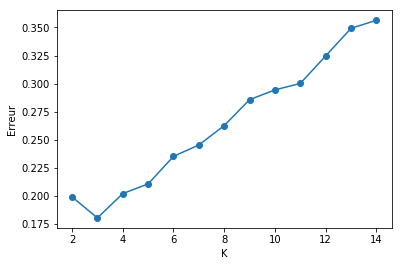

Résultats de la validation croisée :
	accuracy = 0.801 (+/-0.071) for {'n_neighbors': 2}
	accuracy = 0.820 (+/-0.066) for {'n_neighbors': 3}
	accuracy = 0.798 (+/-0.047) for {'n_neighbors': 4}
	accuracy = 0.789 (+/-0.033) for {'n_neighbors': 5}
	accuracy = 0.765 (+/-0.037) for {'n_neighbors': 6}
	accuracy = 0.755 (+/-0.040) for {'n_neighbors': 7}
	accuracy = 0.737 (+/-0.074) for {'n_neighbors': 8}
	accuracy = 0.714 (+/-0.079) for {'n_neighbors': 9}
	accuracy = 0.706 (+/-0.053) for {'n_neighbors': 10}
	accuracy = 0.700 (+/-0.073) for {'n_neighbors': 11}
	accuracy = 0.675 (+/-0.070) for {'n_neighbors': 12}
	accuracy = 0.651 (+/-0.074) for {'n_neighbors': 13}
	accuracy = 0.644 (+/-0.074) for {'n_neighbors': 14}


In [31]:
# Fixer les valeurs des hyperparamètres à tester
params = {'n_neighbors': np.arange(2,15)}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Création du classifieur KNN
knn = neighbors.KNeighborsClassifier()

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
gs_knn = GridSearchCV(knn, # un classifieur kNN
                        params, # hyperparamètres à tester
                        cv = skf, # nombre de folds de validation croisée, on utilise les folds créés précédemment
                        scoring=score # score à optimiser
                        )

# Optimiser ce classifieur sur le jeu d'entraînement
gs_knn.fit(xtrain, ytrain)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",gs_knn.best_params_, 
      "avec une accuracy de", round(gs_knn.cv_results_['mean_test_score'].max(), 3))

# Dessigner l'évolution de l'erreur en fonction du choix de K
print("\nAffichage de l'erreur en fonction du choix de K :")
plt.plot(range(2,15), 1 - gs_knn.cv_results_['mean_test_score'], 'o-')
plt.ylabel('Erreur')
plt.xlabel('K')
plt.show()

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(gs_knn.cv_results_['mean_test_score'], # score moyen
    gs_knn.cv_results_['std_test_score'], # écart-type du score
    gs_knn.cv_results_['params'] # valeur de l'hyperparamètre
    ):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
    mean, # score moyen
    std * 2, # barre d'erreur
    params # hyperparamètre
    ))

Nous allons maintenant prédire sur le jeu xtest pour comparer avec les vrais résultats :

In [25]:
ypred = clf_knn.predict(xtest)
print("\nSur le jeu de test l'accuracy est de %0.3f" % metrics.accuracy_score(ytest, ypred))


Sur le jeu de test l'accuracy est de 0.882


Calculons et affichons la matrice de confusion :

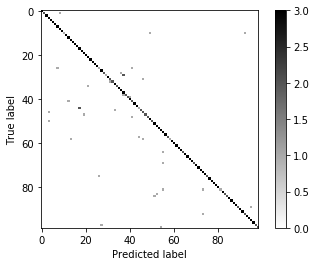

In [26]:
# Calcul de la matrice de confusion
cm_knn = confusion_matrix(ytest, ypred)

# Plot
fig, ax = plt.subplots()
im = ax.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.binary)
ax.figure.colorbar(im, ax=ax)
ax.set(ylabel='True label',
       xlabel='Predicted label')

plt.show()

On peut afficher également les détails de la précision, du recall et du f1-score par espèce d'arbres :

In [28]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         3
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3
          10       1.00      0.33      0.50         3
          11       1.00      1.00      1.00         3
          12       0.75      1.00      0.86         3
          13       0.75      1.00      0.86         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       0.60    

On remarque que certaines cellules sont moins bien classées que d'autres

# Classification avec SVM 

Nous allons d'abord appliquer le principe OVR (One Versus Rest) à une classification linéaire SVM, en testant différents paramètres :  
- le coefficient de régularisation C  
- penalty l1 ou l2
- multi_class : "ovr" ou "crammer_singer" 

Nous allons utiliser la forme primale car le nombre de variables est inférieur aux observations.

Nous n'allons pas préciser la seed pour LinearSVC car cela n'est pas nécessaire lorsqu'on utilise la forme primal.

In [34]:
# On crée le classifieur linéaire SVM
svm = LinearSVC(max_iter = 100, dual = False)

# On crée la grille de paramètres à tester
params = {  'C': np.logspace(-3, 3, 7),
            'multi_class' : ["crammer_singer","ovr"],
            'penalty' : ["l1","l2"]
         }

# On définit le type de score qu'on cherche à optimiser
score = 'accuracy'

# On crée la validation croisée avec GridSearchCV
gs_svm = GridSearchCV(svm, 
                      params, 
                      scoring = score, 
                      cv = skf)

# On lance la validation croisée sur le jeu d'entrainement
gs_svm.fit(xtrain, ytrain)

# On affiche les hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",gs_svm.best_params_, 
      "avec une accuracy de", round(gs_svm.cv_results_['mean_test_score'].max(), 3))

# Afficher les différentes performances
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(gs_svm.cv_results_['mean_test_score'], # score moyen
    gs_svm.cv_results_['std_test_score'], # écart-type du score
    gs_svm.cv_results_['params'] # valeur de l'hyperparamètre
    ):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
    mean, # score moyen
    std * 2, # barre d'erreur
    params # hyperparamètre
    ))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'C': 100.0, 'multi_class': 'ovr', 'penalty': 'l2'} avec une accuracy de 0.941
Résultats de la validation croisée :
	accuracy = 0.810 (+/-0.046) for {'C': 0.001, 'multi_class': 'crammer_singer', 'penalty': 'l1'}
	accuracy = 0.810 (+/-0.034) for {'C': 0.001, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
	accuracy = 0.010 (+/-0.000) for {'C': 0.001, 'multi_class': 'ovr', 'penalty': 'l1'}
	accuracy = 0.548 (+/-0.041) for {'C': 0.001, 'multi_class': 'ovr', 'penalty': 'l2'}
	accuracy = 0.861 (+/-0.029) for {'C': 0.01, 'multi_class': 'crammer_singer', 'penalty': 'l1'}
	accuracy = 0.867 (+/-0.012) for {'C': 0.01, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
	accuracy = 0.010 (+/-0.000) for {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l1'}
	accuracy = 0.573 (+/-0.035) for {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l2'}
	accuracy = 0.863 (+/-0.015) for {'C': 0.1, 'multi_class': 'crammer_singer', 'penalty': 'l1'}
	accuracy = 0

On préférera donc utiliser un C = 100 avec une méthode One-versus-All (OVR) et une régression ridge.
L'erreur est bien plus faible qu'avec le modèle KNN !

Nous allons maintenant prédire sur le jeu xtest pour comparer avec les vrais résultats :

In [35]:
ypred = gs_svm.predict(xtest)
cm_svm = confusion_matrix(ytest, ypred)

print("\nSur le jeu de test l'accuracy est de %0.3f" % metrics.accuracy_score(ytest, ypred))


Sur le jeu de test l'accuracy est de 0.956


Calculons et affichons la matrice de confusion :

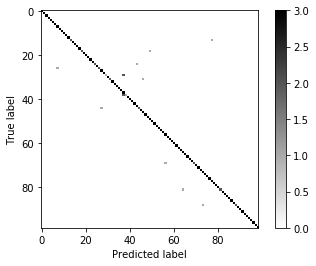

In [36]:
# Calcul de la matrice de confusion
cm_svm = confusion_matrix(ytest, ypred)

# Plot
fig, ax = plt.subplots()
im = ax.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.binary)
ax.figure.colorbar(im, ax=ax)
ax.set(ylabel='True label',
       xlabel='Predicted label')

plt.show()

On peut afficher également les détails de la précision, du recall et du f1-score par espèce d'arbres :

In [42]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       1.00    

# Catégorisation du jeu de test

On commence par charger les données du jeu de test :

In [38]:
feuilles_test = pd.read_csv('test_feuilles.csv')
print(len(feuilles_test), "observations")
feuilles_test.head()

594 observations


,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


On réalise les prédictions avec la méthode SVM (et les meilleurs paramètres sélectionnés) et on ajoute les résultats au dataframe :

In [39]:
feuilles_test_pred = gs_svm.predict(feuilles_test.iloc[:,1:])
feuilles_test['pred'] = feuilles_test_pred

Comme on avait encodé les espèces d'arbres en nombres, on va les décoder :

In [44]:
feuilles_test['species'] = labelencoder.inverse_transform(feuilles_test['pred'])

In [50]:
feuilles_test.iloc[:, [0, -2, -1]]

,id,pred,species
0,4,51,Quercus_Agrifolia
1,7,50,Quercus_Afares
2,9,1,Acer_Circinatum
3,12,19,Castanea_Sativa
4,13,14,Alnus_Viridis
5,16,3,Acer_Opalus
6,19,3,Acer_Opalus
7,23,28,Eucalyptus_Glaucescens
8,24,84,Quercus_Variabilis
9,28,8,Acer_Rufinerve
